In [2]:
import pandas as pd
import numpy as np
import spacy
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report


# Load Spacy model and set up stop words and punctuations

In [3]:
#Load Spacy model and set up stop words and punctuation
nlp = spacy.load("en_core_web_sm")
stop_words = nlp.Defaults.stop_words
punctuations = string.punctuation


In [4]:
#function for tokenizing the input sentence
def spacy_tokenizer(sentence, count_words=False):
    # Check if the input is of type float
    if type(sentence) == float:
        sentence = sentence
    else:
        # If it's not a float, tokenize the sentence using spaCy
        doc = nlp(sentence)
        mytokens = [word.lemma_.lower().strip() for word in doc]
        mytokens = [word for word in mytokens if word not in stop_words and word not in punctuations]
        sentence = " ".join(mytokens)
        
    # If count_words is True, also return the word count
    if count_words:
        word_count = len(mytokens)
        return sentence, word_count
    # If count_words is False, return only the processed sentence
    else:
        return sentence



In [5]:
# Load data
data = pd.read_csv("llm-detect-ai-generated-text/train_essays.csv")
data.head()



,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [6]:
# Tokenize and preprocess the text data
data[['tokenized_Response', 'count']] = data['text'].apply(lambda x: pd.Series(spacy_tokenizer(x, count_words=True)))



In [7]:
# Build a vocabulary and reverse index
vectorizer = CountVectorizer()
X_vec = vectorizer.fit_transform(data['tokenized_Response'])
vocab = vectorizer.get_feature_names_out() 
reverse_index = {word: index for index, word in enumerate(vocab)}


In [8]:

# Calculate probability of occurrence
total_documents = len(data)
word_occurrences = np.array(X_vec.sum(axis=0)).flatten()

occurrence_probs = word_occurrences / total_documents



In [9]:
# Calculate conditional probability based on the class (human or LLM)
llm_indices = data[data['generated'] == 1].index
human_indices = data[data['generated'] == 0].index


In [18]:
# Calculate the number of documents in the llm and human groups
llm_documents = len(llm_indices)
human_documents = len(human_indices)

# Calculate word occurrences for each group and flatten the result
llm_word_occurrences = np.array(X_vec[llm_indices].sum(axis=0)).flatten()
human_word_occurrences = np.array(X_vec[human_indices].sum(axis=0)).flatten()

# Calculate the probabilities of each word occurring in the llm and human groups
llm_probs = llm_word_occurrences / llm_documents
human_probs = human_word_occurrences / human_documents

# Calculate accuracy using dev dataset
y = data['generated']
x_dev = vectorizer.transform(data['tokenized_Response'])
y_dev = data['generated']



In [19]:
# Naive Bayes Classifier Implementation
class NaiveBayesClassifier:
    def __init__(self, alpha=1):
        self.alpha = alpha
        self.class_probs = None
        self.word_probs = None

    def fit(self, X, y):
        num_docs, vocab_size = X.shape
        unique_classes = np.unique(y)
        num_classes = len(unique_classes)

        # Calculate class probabilities
        self.class_probs = np.zeros(num_classes)
        for i, c in enumerate(unique_classes):
            self.class_probs[i] = np.sum(y == c) / num_docs

        # Calculate word probabilities with Laplace smoothing
        self.word_probs = np.zeros((num_classes, vocab_size))
        for i, c in enumerate(unique_classes):
            class_docs = X[y == c]
            total_words_in_class = np.sum(class_docs)
            self.word_probs[i] = (np.sum(class_docs, axis=0) + self.alpha) / (total_words_in_class + self.alpha * vocab_size)

            
    def predict_proba(self, X):
        num_docs, _ = X.shape
        num_classes, vocab_size = self.word_probs.shape

        # Use log probabilities to avoid underflow
        log_class_probs = np.log(self.class_probs)
        log_word_probs = np.log(self.word_probs)

        # Calculate log likelihoods for each class
        log_likelihoods = np.zeros((num_docs, num_classes))
        for i in range(num_docs):
            doc = X[i].toarray().flatten()  # Convert the sparse matrix to a dense array
            log_likelihoods[i] = np.sum(log_word_probs * doc, axis=1) + log_class_probs

        # Convert log likelihoods to probabilities using softmax
        exp_log_likelihoods = np.exp(log_likelihoods - np.max(log_likelihoods, axis=1, keepdims=True))
        probabilities = exp_log_likelihoods / np.sum(exp_log_likelihoods, axis=1, keepdims=True)

        return probabilities        
    
    def predict(self, X):
        num_docs, _ = X.shape
        num_classes, vocab_size = self.word_probs.shape

        # Use log probabilities to avoid underflow
        log_class_probs = np.log(self.class_probs)
        log_word_probs = np.log(self.word_probs)

        # Calculate log likelihoods for each class
        log_likelihoods = np.zeros((num_docs, num_classes))
        for i in range(num_docs):
            doc = X[i].toarray().flatten()  # Convert the sparse matrix to a dense array
            log_likelihoods[i] = np.sum(log_word_probs * doc, axis=1) + log_class_probs

        # Predict the class with the highest log likelihood
        predictions = np.argmax(log_likelihoods, axis=1)
        return predictions



In [20]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, stratify=y)



In [21]:
# Create and train the Naive Bayes Classifier
alpha_value = 1  # You can experiment with different alpha values
custom_nb_classifier = NaiveBayesClassifier(alpha=alpha_value)
custom_nb_classifier.fit(x_train, y_train)


In [23]:

# Make predictions on the dev set
y_pred_custom = custom_nb_classifier.predict(x_dev)

# Print classification report
print("Classification Report on Dev Set:")
print(classification_report(y_pred_custom, y_dev))


Classification Report on Dev Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1375
           1       0.00      0.00      0.00         3

    accuracy                           1.00      1378
   macro avg       0.50      0.50      0.50      1378
weighted avg       1.00      1.00      1.00      1378



In [24]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt


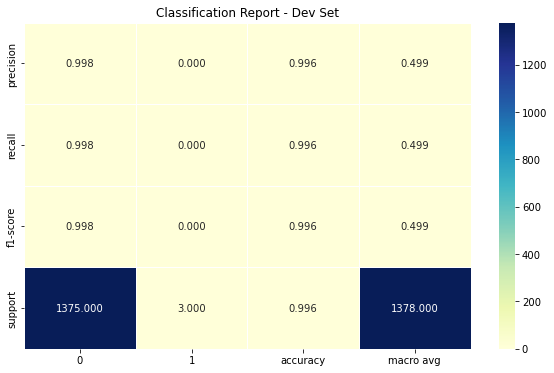

In [25]:
# Visualize the classification report
report = classification_report(y_dev, y_pred_custom, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(df_report.iloc[:-1, :].T, annot=True, cmap="YlGnBu", fmt=".3f", linewidths=.5)
plt.title("Classification Report - Dev Set")
plt.show()


In [26]:
# Comparing the effect of Smoothing
alpha_values = [0.1, 0.5, 1, 2, 5]
for alpha in alpha_values:
    custom_nb_classifier = NaiveBayesClassifier(alpha=alpha)
    custom_nb_classifier.fit(x_train, y_train)
    y_pred_custom = custom_nb_classifier.predict(x_dev)
    accuracy = np.mean(y_pred_custom == y_dev)
    print(f"Accuracy with Smoothing (alpha={alpha}): {accuracy}")

    

Accuracy with Smoothing (alpha=0.1): 0.9898403483309144
Accuracy with Smoothing (alpha=0.5): 0.9920174165457184
Accuracy with Smoothing (alpha=1): 0.9956458635703919
Accuracy with Smoothing (alpha=2): 0.9963715529753265
Accuracy with Smoothing (alpha=5): 0.9963715529753265


Accuracy with Smoothing (alpha=0.1): 0.9898403483309144
Accuracy with Smoothing (alpha=0.5): 0.9920174165457184
Accuracy with Smoothing (alpha=1): 0.9956458635703919
Accuracy with Smoothing (alpha=2): 0.9963715529753265
Accuracy with Smoothing (alpha=5): 0.9963715529753265


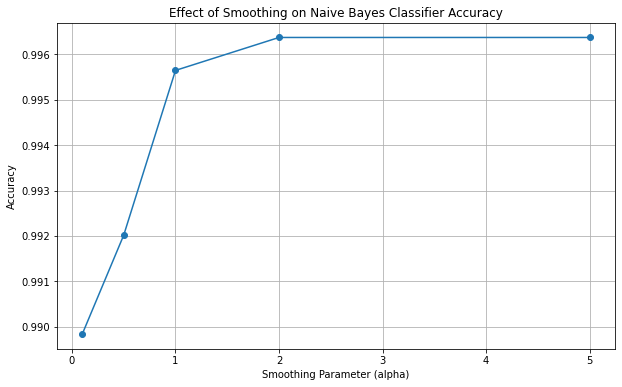

In [27]:
import matplotlib.pyplot as plt

alpha_values = [0.1, 0.5, 1, 2, 5]
accuracies = []

for alpha in alpha_values:
    custom_nb_classifier = NaiveBayesClassifier(alpha=alpha)
    custom_nb_classifier.fit(x_train, y_train)
    y_pred_custom = custom_nb_classifier.predict(x_dev)
    accuracy = np.mean(y_pred_custom == y_dev)
    accuracies.append(accuracy)
    print(f"Accuracy with Smoothing (alpha={alpha}): {accuracy}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, accuracies, marker='o')
plt.title('Effect of Smoothing on Naive Bayes Classifier Accuracy')
plt.xlabel('Smoothing Parameter (alpha)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


In [28]:
# Derive Top 10 words that predict each class
top_words_llm = [vocab[i] for i in np.argsort(llm_probs)[-10:]]
top_words_human = [vocab[i] for i in np.argsort(human_probs)[-10:]]

print("Top 10 words predicting LLM:")
print(top_words_llm)
print("\nTop 10 words predicting Human:")
print(top_words_human)

# Using the test dataset
test_df = pd.read_csv('llm-detect-ai-generated-text/test_essays.csv')
test_df['tokenized_Response'] = test_df['text'].apply(spacy_tokenizer)
test_vec = vectorizer.transform(test_df['tokenized_Response'])



Top 10 words predicting LLM:
['citizen', 'president', 'elector', 'car', 'candidate', 'college', 'win', 'electoral', 'state', 'vote']

Top 10 words predicting Human:
['candidate', 'elector', 'use', 'president', 'state', 'college', 'people', 'electoral', 'vote', 'car']


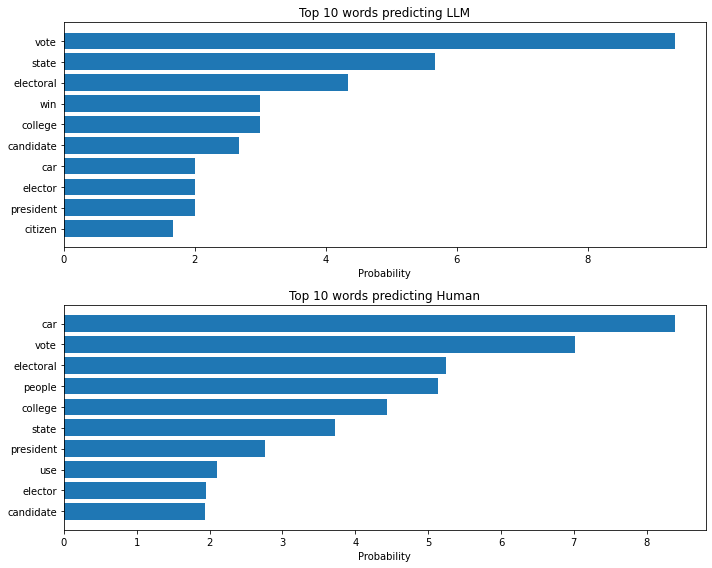

In [30]:
import matplotlib.pyplot as plt

# Assuming you have llm_probs and human_probs defined
top_words_llm = [vocab[i] for i in np.argsort(llm_probs)[-10:]]
top_words_human = [vocab[i] for i in np.argsort(human_probs)[-10:]]

# Plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Bar plot for Top 10 words predicting LLM
ax1.barh(top_words_llm, llm_probs[np.argsort(llm_probs)[-10:]])
ax1.set_title('Top 10 words predicting LLM')
ax1.set_xlabel('Probability')

# Bar plot for Top 10 words predicting Human
ax2.barh(top_words_human, human_probs[np.argsort(human_probs)[-10:]])
ax2.set_title('Top 10 words predicting Human')
ax2.set_xlabel('Probability')

plt.tight_layout()
plt.show()


In [32]:
submit = pd.read_csv('llm-detect-ai-generated-text/sample_submission.csv')

# custom_nb_classifier is the trained Naive Bayes classifier
for i in range(len(submit)):
    output_arr = custom_nb_classifier.predict_proba(test_vec[i])
    submit.iloc[i, 1] = output_arr[0][0]

submit.to_csv('submission.csv', index=False)
submit.head()


,id,generated
0,0000aaaa,0.998185
1,1111bbbb,0.998185
2,2222cccc,0.998185
